In [44]:
from typing import List, Dict, Tuple, Set

In [45]:
from pathlib import Path

DATA = Path("scrape")
assert DATA.is_dir()

In [46]:
from ipyfilechooser import FileChooser
from ipywidgets import Layout

fc = FileChooser(
    DATA,
    filter_pattern="*.pdf",
    title="Select PDF file to extract",
    layout=Layout(width="100%"),
)
display(fc)

FileChooser(path='/home/bdrad/Documents/Vogel/book-scrape/scrape', filename='', title='Select PDF file to extr…

In [47]:
# fname = Path(fc.selected)
fname = Path('/home/bdrad/Documents/Vogel/book-scrape/scrape/Chest - Webb - Fundamentals of Body CT (4e).pdf')
assert fname.is_file()
print(f"File selected: [{fname.name}]({fname.as_uri()})")

File selected: [Chest - Webb - Fundamentals of Body CT (4e).pdf](file:///home/bdrad/Documents/Vogel/book-scrape/scrape/Chest%20-%20Webb%20-%20Fundamentals%20of%20Body%20CT%20%284e%29.pdf)


In [48]:
import fitz

pdf: fitz.Document = fitz.Document(fname)
# pdf: fitz.Document = fitz.open(fname)

In [49]:
class Config:
    # todo typeing for font_* sets
    odd_spread = True  # inner corresponds to right-side of odd pages, left-side of even pages
    crop_top: int = 0
    crop_inner: int = 0
    crop_bot: int = 0
    crop_outer: int = 0
    font_header: Set[Tuple[int, str]] = set()
    font_body: Set[Tuple[int, str]] = set()
    font_ignore: Set[Tuple[int, str]] = set()
    font_ignore_names: Set[str] = set()
    chapters: List[int] = None

    def __init__(self, fname: Path):
        match fname.name:
            case "Chest - Elicker - HRCT of the Lungs 2e.pdf":
                self.crop_top = 65
                self.crop_inner = 40
                self.crop_bot = 30
                self.crop_outer = 40
                self.chapters = [49, 62, 83, 104, 116, 129, 150, 166, 174, 199, 212, 221, 233, 247, 265, 274, 283, 296, 305]
                
            case "Chest - Felson - Principles of Chest Roentgenology (4e).pdf":
                self.crop_top = 50
                self.crop_inner = 40
                self.crop_bot = 50
                self.crop_outer = 50
                self.chapters = [8,29,46,68,84,104,122,136,160,182,202,226] # TODO rest of chpts

            case "Chest - Webb - Fundamentals of Body CT (4e).pdf":
                self.crop_top = 60
                self.crop_inner = 40
                self.crop_bot = 30
                self.crop_outer = 30
                self.font_header = {(13.0, 'Univers-CondensedBold'), (10.0, 'Univers-BoldOblique')}
                self.font_body = {
                    (10.0, "JansonText-Roman"),
                    (10.0, "JansonText-Italic"),
                    (10.0, 'JansonText-Bold'),
                    (10.0, 'JansonText-BoldItalic'),
                    (10.0, 'TnQ'), # greek characters
                }
                self.font_ignore = {
                    (16.0, "JansonText-Roman"),  # chapter title font
                    (7.199999809265137, "JansonText-Roman-SC800"),
                    (9.0, "JansonText-Roman-SC800"),
                    (27.0, "JansonText-Roman-SC800"),
                    (21.600000381469727, "JansonText-Roman-SC800"),
                    (8.0, 'Univers-CondensedBold'), # figure labels
                    # (9.0, 'JansonText-Bold'), # todo these are numbers; verify they're not needed
                    (8.0, 'Univers-BoldOblique'), # figure labels
                    (10.0, 'Univers-CondensedBold'), # page numbers
                    (16.0, 'JansonText-Bold'), # chapter number
                }
                self.font_ignore_names = {'Helvetica',   # figures
                                          'Helvetica-Bold',
                                          'ZapfDingbats', # bullet points
                                          'Univers', # table body
                                          'Univers-Light', # table footer
                                          'Univers-Oblique', # figure arrows
                                          'Univers-Bold', # table header
                                          'Univers-Condensed', # table label
                                        #   'Sabon-Roman'
                }
                # Chapters are zero-indexed, and final number is the last page of the final chapter
                self.chapters = [6,12,26,49,73,94,134,151,176,188,214,225,241,250,278,290,323,340,349,363,370,]
            case "General - Mandell - Core Radiology (1e).pdf":
                self.crop_top = 10
                self.crop_inner = 30
                self.crop_bot = 30
                self.crop_outer = 30
                self.font_header = {(11.0, 'TwCenMT-CondensedExtraBo'),
                                    (18.0, 'Calibri-Bold'),
                                    (14.0, 'Calibri-Bold'),}    
                self.font_body = {(12.0, 'Calibri'),(10.0, 'Calibri'),(10.0, 'Calibri-Bold')}
                self.font_ignore_names = {'ArialMT','MyriadPro-Regular','MyriadPro-It','Wingdings2'}
                self.font_ignore = {(-1, ''),} 
                self.chapters = [669,702]
            case _:
                raise KeyError
            
        
        overlapping_fonts = self.font_ignore_names.intersection([x[1] for x in self.font_body.union(self.font_header)])
        assert not overlapping_fonts, f"These fonts are both ignored and included: {overlapping_fonts}"

    def chapter_range(self):
        return list(zip(self.chapters, self.chapters[1:]))

    def contained_chapter(self, page: fitz.Page, chapter_range=None):
        chapter_range = chapter_range or self.chapter_range()
        for i, (start, end) in enumerate(chapter_range):
            if (start or float("-inf")) <= page.number < (end or float("inf")):
                return i
        return None

    def get_cropbox(self, pg: fitz.Page):
        inr, outr = self.crop_inner, self.crop_outer
        if ((pg.number + 1) % 2) and config.odd_spread:
            inr, outr = outr, inr

        return (
            outr,
            config.crop_top,
            pg.rect.width - inr,
            pg.rect.height - config.crop_bot,
        )

    def crop_page(self, pg: fitz.Page):
        if pg.cropbox_position == fitz.Point():  # botched to check if cropbox is not set
            crop_box = self.get_cropbox(pg)
            pg.set_cropbox(crop_box)


config = Config(fname)

# config.chapter_range()

In [50]:
# pages = pdf[config['pg_start']:]
start, end = config.chapter_range()[0]
# print(start,end)

# pages = pdf[start:end]

pdf.select(range(start, end))

print(len(pdf))

6


In [51]:
pg: fitz.Page = pdf[1]

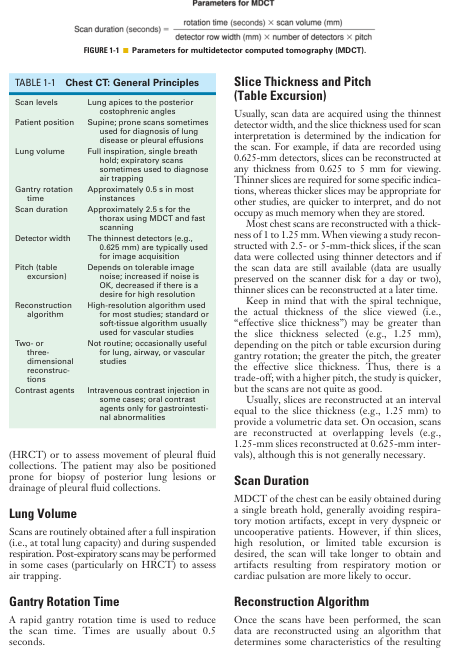

<Figure size 1000x1000 with 0 Axes>

In [52]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


def page_to_img(pg: fitz.Page, config=config):
    im: fitz.Pixmap = pg.get_pixmap(clip=config.get_cropbox(pg))
    bytes = im.tobytes("png")
    return Image.open(BytesIO(bytes))


# crop_page(pg)
im=page_to_img(pg)

plt.figure(figsize=(10,10))
display(im)

In [16]:
# print(pg.get_text())

# processing text

In [53]:
import re

In [54]:
import nltk
# nltk.download('wordnet31')

from nltk.corpus import wordnet31 as wordnet

hyphen_corpus = set(filter(lambda w: "-" in w, wordnet.words()))    # select just words with hyphen
hyphen_corpus = hyphen_corpus.union({'Three-dimensional', 'Multiple-detector', 'Two-and', 'Multiple-detector', 'four-detector-row','Post-expiratory','soft-tissue','two-or','arrowhead-shaped','fat-filled','short-axis','out-flow','mirror-image','left-sided','Contrast-enhanced','post-traumatic','x-rays','medullary-based','MDCT-guided','volume-rendered','volume-rendering','contrast-opacified','thick-walled','thin-walled','bolus-contrast-enhanced','Contrast-filled','smooth-outlined','sheet-like','small-bowel','Colon-wall','tumor-involved','Early-stage','Closed-loop','B-cell','Mucosa-associated','three-layer','region-of-interest','lipid-rich','Lipid-poor', 'non-Hodgkin’s','fat-containing','bone-marrow','Thin-section','Axial-plane','sagittal-plane','well-hydrated','end-stage','image-guided','fluid-filled','non-neoplastic','hairline-thin','well-marginated','Lymphad-enectomy','Nephron-sparing','mid-T-12','CT-KUB','CT-IVP','water-density','bunch-of-grapes','main-duct','branch-duct','duct-obstructing','AIDS-related','Hormone-producing','ultrasound-guided','Long-segment','upper-quadrant','IV-A','IV-B','tech-netium-99m-labeled','technetium-99m','delayed-phase','Well-differentiated','venous-phase','arterial-phase','arterial-phase','nodule-in-nodule','False-positive','comma-shaped',})


hyphen_corpus = set(map(lambda w: w.lower(), hyphen_corpus))    # lower case

# TODO use trie to speed up?

len(hyphen_corpus)

7124

In [55]:
# TODO: words such as high-XXX, minimum-XXX, etc. should not be de-hyphenated
# Need to get such prefix words (prefix corpus)
# Need to evaluate the prefix (that before '-') and determine if it is in this prefix corpus

hyphen_prefixs = {'high', 'higher', 'highest',
                  'low', 'lower', 'lowest',
                  'max', 'maximum',
                  'min', 'minimum',
                  }

hyphen_sufffixs = {'mm', 'cm', 'm'}

In [56]:
def dehyphenate_string(input_string):
    out = ""
    dehyphens = []

    input_string = re.sub(r"\s*-\s*", r"-", input_string)   # remove surronding spaces; join hyphenated words

    re_number =  r'^\d+(\.\d+)?-(.+)$'      # e.x. 15.25-mm
    re_word_extract = r'^(\W*)([\w-]*)(\W*)$'
    re_hyph_split = r'^([^-]*)-(.*)$'

    for full_word in input_string.split():
        if "-" not in full_word or re.match(re_number, full_word):
            out += full_word + " "
            continue
        
        try:
            # ! this is broken by " non-Hodgkin’s "
            match = re.search(re_word_extract, full_word)
            pre, word, post = match.groups()
            assert '-' in word

            match = re.search(re_hyph_split, word)
            word_pre, word_post = match.groups()
        except AttributeError:
            print(f"### Failed to dehyphenate word: {full_word}")
            out += full_word + " "
            continue
        
        if word_pre.lower() not in hyphen_prefixs and word_post.lower() not in hyphen_sufffixs:
            if word.lower() not in hyphen_corpus:
                # print('Dehyphenating word: ', word)
                dehyphens.append(word)
                word = word_pre + word_post
        out += pre + word + post + " "
    return out, dehyphens


dehyphenate_string("This is an ex-ample of a de-hyphenated string. x-ray is a hyphenated word. 15.25-mm is a hyphenated number.")

('This is an example of a dehyphenated string. x-ray is a hyphenated word. 15.25-mm is a hyphenated number. ',
 ['ex-ample', 'de-hyphenated'])

In [57]:
def process_text(text: str) -> str:
    
    sentences = re.split(r'(?<=[.?!;\n])', text)    # this will split, but preserve the delimiter
    out = ""
    for sent in sentences:
        if not sent: continue
        
        ref_parenthesis = r" ?\(.*(Table|Fig(\.|ure)) \d.+?\)"    # e.x. (lorem Table 1 ipsum) or (Fig. 2.1)
        sent = re.sub(ref_parenthesis, "", sent)

        ref_whole = r"(Table|Fig(\.|ure)) \d"
        if re.search(ref_whole, sent):
            continue

        sent, dehyphs = dehyphenate_string(sent)
        if dehyphs: print("De-hyphenated:", dehyphs)
        out += sent
    
    return out.strip()

# test_txt = """Because scan data are acquired continuously and volumetrically using spiral CT, scans may be reconstructed in any plane desired, if appropriate workstations are available. A variety of display techniques have been used for imaging the tho-rax. These include multiplanar reconstructions, three-dimensional shaded surface display or vol-ume rendering from an external perspective, or shaded surface or volume rendering from an internal (i.e., endoluminal) perspective, also known as virtual bronchoscopy.
# Multiplanar, two-dimensional reconstructions offer the advantage of being quickly performed and are sufficient for diagnosis in most cases in which a reformation is considered desirable. Subsequent chapters provide a number of examples of two-dimensional reconstructions. Three-dimensional techniques, such as shaded surface display and vol-ume rendering, can be valuable in selected cases, but they are time-consuming and require consider-able operator experience. These techniques are not commonly used in clinical chest imaging, with the exception of virtual bronchoscopy or airway imag-ing and specialized vascular imaging.
# Maximum- or minimum-intensity projection images representing a slab of three-dimensional data reconstructed from a volumetric data set may sometimes be useful in imaging pulmonary, airway, or vascular abnormalities."""
test_txt="The specific protocols used for chest CT depend on the scanner used, the scanner manufacturer, and the reason for the study. However, several general principles apply to all chest scans (Table 1-1)."
process_text(test_txt)

'The specific protocols used for chest CT depend on the scanner used, the scanner manufacturer, and the reason for the study. However, several general principles apply to all chest scans.'

# processing pages

In [58]:
import layoutparser as lp

label_map = {0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}
model = lp.models.Detectron2LayoutModel(
                                #  'lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
                                 'lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],   # todo tinker
                                 label_map=label_map)

In [59]:
# pg_layout = model.detect(im) # Detect the layout of the input image
# lp.draw_box(im, pg_layout, box_width=3) # Show the detected layout of the input image

In [60]:
import pdfplumber
from pdfplumber.page import Page
pdf = pdfplumber.open(fname, laparams={"detect_vertical": False}).pages

start, end = config.chapter_range()[0]
pages = pdf[start:end]
pg = pages[0]
# pg.to_image(resolution=123).draw_rects(pg.textboxhorizontals)

pg.bbox[2:]

(522, 738)

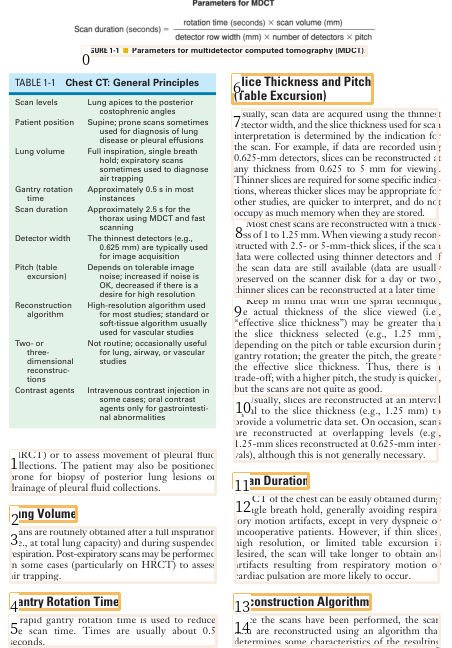

In [61]:
from layoutparser.elements import Layout, Interval
from pdfplumber.page import Page


def get_labels(im) -> Layout: 
    w,h = im.size
    
    layout = model.detect(im) # Detect the layout of the input image
    
    text_blocks: Layout = lp.Layout([b for b in layout if b.type in ('Text', 'Title')])
    figure_blocks: Layout = lp.Layout([b for b in layout if b.type=='Figure'])

    # As there could be text region detected inside the figure region, we just drop them:
    text_blocks: Layout = lp.Layout([b for b in text_blocks if not any(b.is_in(b_fig) for b_fig in figure_blocks)])
    

    # canvas_height=h, canvas_width=w
    left_interval: Interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(im)

    left_blocks = text_blocks.filter_by(left_interval, center=True)
    right_blocks = [b for b in text_blocks if b not in left_blocks]

    sort_key = lambda b: b.coordinates[1]
    left_blocks = sorted(left_blocks, key=sort_key)
    right_blocks = sorted(right_blocks, key=sort_key)

    # print('og\t', len(text_blocks))
    # print('left\t', len(left_blocks))
    # print('right\t', len(right_blocks))

    sorted_boxes = [b.set(id=idx) for idx, b in enumerate(left_blocks + right_blocks)]
    
    return sorted_boxes

sorted_boxes = get_labels(im)

lp.draw_box(im, sorted_boxes, box_width=3, show_element_id=True)

** ignoring overlap case (contained)
1 1 8 12
6 2 11 10


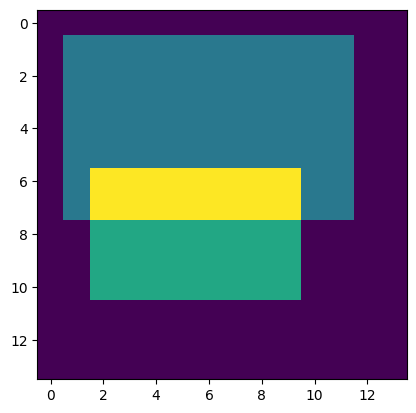

In [65]:
# TODO finish this
import numpy as np
import matplotlib.pyplot as plt
from math import ceil,floor

def place(i,j,data,itm,center=False):
    h,w=itm.shape
    
    if center: 
        i-=h//2
        j-=w//2
    
    data[i:i+h,j:j+w]+=itm
    return data

def rm_overlap(rect0: List[int],rect1: List[int], favor=0, interp=0.66) -> Tuple[List[int], List[int]]:
    assert 0<=interp<=1
    
    x0,y0,x1,y1=rect0
    a0,b0,a1,b1=rect1
    
    # no overlap
    if x1<a0 or a1<x0 or y1<b0 or b1<y0:
        return rect0, rect1
    
    # boxes overlap in x, and y
    if not (x1<a0 or a1<x0) and not (y1<b0 or b1<y0):
        p,q=interp,1-interp
        
        if y0<b0<y1<b1:     # rect0 above rect1
            margin = y1-b0
            y1-=margin*(q if favor else p)
            b0+=margin*(p if favor else q)
            y1,b0=floor(y1),ceil(b0)            
        elif b0<y0<b1<y1:   # rect0 below rect1
            margin = b1-y0
            y0+=margin*(q if favor else p)
            b1-=margin*(p if favor else q)
            y0,b1=ceil(y0),floor(b1)
        else:
            print('** ignoring overlap case (contained)')
    
    # y0,b0=max(y0,0),max(b0,0)
    return [x0,y0,x1,y1], [a0,b0,a1,b1]
    

n = 14
data = np.zeros((n,n))

a_dim = (7,11)
a_off = (1,1)
a = np.ones(a_dim)/3.0
ax0,ay0 = a_off
ax1,ay1 = [a+i for a,i in zip(a_off,a.shape)]


b_dim = (5,8)
b_off = (6,2)
b = np.ones(b_dim)/2.0
bx0,by0 = b_off
bx1,by1 = [b+i for b,i in zip(b_off,b.shape)]

(ax0,ay0,ax1,ay1), (bx0,by0,bx1,by1) = rm_overlap((ax0,ay0,ax1,ay1), (bx0,by0,bx1,by1))
place(*a_off,data,a)
print(ax0,ay0,ax1,ay1)
place(*b_off,data,b)
print(bx0,by0,bx1,by1)

plt.imshow(data, interpolation='nearest');

In [41]:
from layoutparser.elements import TextBlock

def process_page_DNN(pg: Page, pad=0.005):
    assert 0<=pad<1
    continuation = ""   # base text continuing from previous page's last entry
    mode = "startup"    # startup, header, body
    entries = []        # list of (header, text) tuples
    current_entry = ["", ""]  # current entry (header, text)
    done = False        # whether we've reached the end of the chapter (e.x. sugguested readings section)
    
    TERM_PUNC = ('.','!','?')
    SKIP_BADPUNC = True
    
    im = pg.to_image(resolution=123).annotated
    labels = get_labels(im)
    
    w_im,h_im = im.size
    w_pg,h_pg = pg.width,pg.height
    w_ratio,h_ratio = w_pg/w_im,h_pg/h_im
    
    for i,label in enumerate(labels):
        label: TextBlock
        # print(label)
        
        kind = label.type
        assert kind in ("Text", "Title")
                
        x0,y0,x1,y1 = label.coordinates
        x0,x1 = (x0-pad*w_im)*w_ratio, (x1+pad*w_im)*w_ratio
        y0,y1 = (y0-pad*h_im)*h_ratio, (y1+pad*h_im)*h_ratio
        
        # TODO detect+rm overlap (ensure text is not duplicated)
        
        section = pg.crop((x0,y0,x1,y1))
        sec = section.to_image(resolution=123).annotated
        # plt.imshow(sec)
        # display(sec)

        txt = pg.within_bbox((x0,y0,x1,y1)).extract_text()
        txt = process_text(txt)
        # print(txt)
        
        if txt == 'SUGGESTED READING':
            print('### Found end of chapter, stopping early ###')
            done = True
            if mode == "body":
                entries.append([ent.strip() for ent in current_entry])
            return entries, continuation.strip(), done

        if kind == "Title":
            match mode:
                case "startup":
                    if not continuation.strip().endswith(TERM_PUNC):
                        print(f'### Box {i}: Continuation does not end with punctuation {continuation.strip()[-1]}')
                        if SKIP_BADPUNC: 
                            print(f'### > skipping `{txt}`')
                            continue
                    mode = "header"
                    current_entry = [txt, ""]
                case "header":
                    current_entry[0] += txt
                case "body":
                    if not current_entry[1].strip().endswith(TERM_PUNC):
                        print(f'### Box {i}: Body does not end with punctuation:')
                        if SKIP_BADPUNC: 
                            print(f'### > skipping `{txt}`')
                            continue
                    mode = "header"
                    entries.append([ent.strip() for ent in current_entry])
                    current_entry = [txt, ""]
        elif kind == "Text":
            match mode:
                case "startup":
                    if txt.endswith(TERM_PUNC):
                        txt += "\n"
                    continuation += txt
                case "header":
                    mode = "body"
                    current_entry[1] += txt
                case "body":
                    # if re.match(r'[.?!]', txt[-1]):
                    if txt.endswith(TERM_PUNC):
                        txt += "\n"
                    current_entry[1] += txt

    match mode:
        case "body":
            entries.append([ent.strip() for ent in current_entry])
        case "header", "startup":
            print("### Ended on", mode, "-- this should not happen")
    
            
    continuation = process_text(continuation)
    for i, (_h, b) in enumerate(entries):
        entries[i][1] = process_text(b)

    return entries, continuation, done

    
ent, cont, done = process_page_DNN(pg)

print('\n' + '='*80)
print("cont:", cont, "\n")
for h, b in ent:
    print("**", h, "**")
    print(b)
    print()

### Box 5: Body does not end with punctuation:
### > skipping `I ct ntroductIon to of t : c ct the horax hest t echnIques`
De-hyphenated: ['tho-']
De-hyphenated: ['degra-']

cont: Spiral or helical computed tomography (CT) allows the entire chest to be easily imaged during a single breath hold, with volumetric acquisition and exact registration or overlapping of slices. Two-and three-dimensional reformations may be performed if desired. Because scanning is rapid, contrast agents can be injected quickly, excellent vascular opacification can be achieved, and reduced volumes of contrast agent can be used. 

** SPIRAL CT IN CHEST DIAGNOSIS **
Multiple-detector CT (MDCT) scanners have multiple parallel rows (e. g. , 64, 16, or 4) of x-ray detectors, although the number varies with the machine. Generally speaking, MDCT scanners with fewer rows (e. g. , 16 or 4) are being replaced with scanners having more rows (e. g. , 64), but this is an expensive and, therefore, gradual process. With MDCT,

In [171]:
def process_page(pg: fitz.Page):
    # page_to_img(pg).show()

    continuation = ""  # base text continuing from previous page's last entry
    mode = "startup"  # startup, header, body
    entries = []  # list of (header, text) tuples
    current_entry = ["", ""]  # current entry (header, text)
    done = False # whether we've reached the end of the chapter (e.x. sugguested readings section)

    flags = fitz.TEXTFLAGS_DICT & ~fitz.TEXT_PRESERVE_IMAGES & fitz.TEXT_DEHYPHENATE

    # tessdata=Path('/usr/share/tessdata')
    tp = pg.get_textpage(flags=flags)   # default behavior
    # tp = pg.get_textpage_ocr(flags=flags, full=True, dpi=300, tessdata=tessdata)   # full
    # tp = pg.get_textpage_ocr(flags=flags, full=False, tessdata=tessdata)   # partial

    dict = pg.get_text("dict", textpage=tp, flags=flags, clip=config.get_cropbox(pg))
    blocks = dict["blocks"]
    for block in blocks:
        for line in block["lines"]:
            for span in line["spans"]:
                txt = span["text"]

                if txt == 'SUGGESTED READING':
                    print('### Found end of chapter, stopping early ### ')
                    done = True
                    if mode == "body":
                        entries.append([ent.strip() for ent in current_entry])
                    return entries, continuation.strip(), done

                # if txt.endswith("-") and abs(w["x1"] - x1) < 0.08 * pg.width:

                font = (span["size"], span["font"])
                # print(font, txt)
                if font in config.font_ignore or span["font"] in config.font_ignore_names:
                    continue
                elif font in config.font_header:
                    match mode:
                        case "startup":
                            mode = "header"
                            current_entry = [txt, ""]
                        case "header":
                            current_entry[0] += txt
                        case "body":
                            mode = "header"
                            entries.append([ent.strip() for ent in current_entry])
                            current_entry = [txt, ""]
                elif font in config.font_body:
                    match mode:
                        case "startup":
                            if txt.endswith("."):
                                txt += "\n"
                            continuation += txt
                        case "header":
                            mode = "body"
                            current_entry[1] += txt
                        case "body":
                            if txt.endswith("."):
                                txt += "\n"
                            current_entry[1] += txt
                else:
                    if txt.strip():
                        print(f"Page {pg.number}: unknown font-pair {font}, ignoring text: '{txt}'")

    match mode:
        case "body":
            entries.append([ent.strip() for ent in current_entry])
        case "header", "startup":
            print("### Ended on", mode, "-- this should not happen")
    
            
    continuation = process_text(continuation)
    for i, (_h, b) in enumerate(entries):
        entries[i][1] = process_text(b)

    return entries, continuation, done


ent, cont, done = process_page(pg)


print('\n' + '='*80)
print("cont:", cont, "\n")
for h, b in ent:
    print("**", h, "**")
    print(b)
    print()

De-hyphenated: ['tho-racic']
De-hyphenated: ['degra-dation']

cont: Spiral or helical computed tomography (CT) allows the entire chest to be easily imaged during a single breath hold, with volumetric acquisition and exact registration or overlapping of slices. Two-and three-dimensional reformations may be performed if desired. Because scanning is rapid, contrast agents can be injected quickly, excellent vascular opacification can be achieved, and reduced volumes of contrast agent can be used. 

** SPIRAL CT IN CHEST DIAGNOSIS **
Multiple-detector CT (MDCT) scanners have multiple parallel rows (e. g. , 64, 16, or 4) of x-ray detectors, although the number varies with the machine. Generally speaking, MDCT scanners with fewer rows (e. g. , 16 or 4) are being replaced with scanners having more rows (e. g. , 64), but this is an expensive and, therefore, gradual process. With MDCT, each of the detector rows records data independently as the gantry rotates; consequently, a volume of the patie

In [184]:
from tqdm.notebook import tqdm
import csv


def process_file(fname: Path):
    config = Config(fname)
    chapters = config.chapter_range()
    # chapters = [config.chapter_range()[0]]
    for i, ch in enumerate(chapters, 1):
        pdf: fitz.Document = fitz.open(fname)
        pdf.select(range(*ch))
        print(f"Processing {i}:\t{ch[0]}-{ch[1]}")

        rows = ['header','body']
        ch_entries = [rows]
        
        for pg in pdf:
            entries, cont, done = process_page(pg)

            if cont:
                if ch_entries and ch_entries[-1] != rows:
                    ch_entries[-1][1] = ch_entries[-1][1] + cont
                else:
                    ch_entries.append(["Chapter Introduction", cont])

            ch_entries += entries 

            if done:
                break

        outdir = Path("scrape_out")
        outdir.mkdir(exist_ok=True)
        with open(outdir / f"{fname.stem}_ch{i}.csv", "w") as f:
            writer = csv.writer(f)
            writer.writerows(ch_entries)

            print(f"Saved to {f.name}")
        

process_file(fname)

Processing 1:	6-12
De-hyphenated: ['tho-racic']
De-hyphenated: ['degra-dation']
De-hyphenated: ['indica-tions']
De-hyphenated: ['thick-ness']
De-hyphenated: ['recon-structed']
De-hyphenated: ['inter-vals']
De-hyphenated: ['respira-tory']
Page 2: unknown font-pair (9.0, 'JansonText-Bold'), ignoring text: '1 '
De-hyphenated: ['per-formed']
De-hyphenated: ['tho-rax']
De-hyphenated: ['vol-ume']
De-hyphenated: ['vol-ume', 'consider-able']
De-hyphenated: ['imag-ing']
De-hyphenated: ['dem-onstrate', 'dif-ferentiation', 'con-trast-opacified']
De-hyphenated: ['consoli-dated', 'struc-tures']
De-hyphenated: ['skel-etal']
De-hyphenated: ['win-dow']
De-hyphenated: ['medi-astinum']
De-hyphenated: ['spe-cific']
De-hyphenated: ['Subse-quent']
De-hyphenated: ['eas-ily']
De-hyphenated: ['gen-eral', 'scan-ners']
De-hyphenated: ['con-trast']
De-hyphenated: ['abnor-malities']
De-hyphenated: ['pro-vides', 'struc-tures']
De-hyphenated: ['injec-tion']
De-hyphenated: ['diagno-sis']
De-hyphenated: ['usu-ally']


# `pdfplumber` code; outdated

In [36]:
import pdfplumber

pdf = pdfplumber.open(fname, laparams={"detect_vertical": False}).pages

In [37]:
start, end = config.chapter_range()[0]
pages = pdf[start:end]
pg = pages[3]
pg.to_image(resolution=123).draw_rects(pg.textboxhorizontals).show()

In [54]:
# text = pg.extract_text()
# print(text)

words = pg.extract_words()
words = pg.extract_words(use_text_flow=True, x_tolerance=7, keep_blank_chars=True)
print(" ".join([w['text'] for w in words]))

Acute aortic syndrome overview of acute aortic syndrome •  Acute aorti c syndrome represents a clinical spectrum of three related diseases  that are characterized by damage to at least one component of the aorti c wall, and  presents as severe chest pain. •  A defect primarily in the inti ma is seen in penetrati ng atheroscleroti c ulcer (PAU). •  A defect in the media only describes intramural hematoma (ImH). •  A defect in the inti ma extending to media is the hallmark of aorti c dissecti on. •  A defect in all three layers (aorti c transecti on) is almost always due to trauma and is  considered a separate enti ty. •  The treatment of acute aorti c syndrome depends primarily on the locati on (ascending  versus descending aorta) and is oft en the same regardless of the underlying eti ology. Ascending aorta: Treatment is most commonly surgical. Descending aorta: Treatment is most commonly medical (blood pressure control). •  Imaging of the full aorta is generally required in any acute 

In [18]:
from pdfplumber.page import Page
from collections import deque


def process_page(pg: Page):
    assert not isinstance(pg, pdfplumber.page.CroppedPage)
    assert pg.textboxhorizontals, "Pass `laparams={...}` when opening the PDF file"

    if (pg.page_number % 2) and config["odd_spread"]:
        crop_box = (
            config["crop_outer"],
            config["crop_top"],
            pg.width - config["crop_inner"],
            pg.height - config["crop_bot"],
        )
    else:
        crop_box = (
            config["crop_inner"],
            config["crop_top"],
            pg.width - config["crop_outer"],
            pg.height - config["crop_bot"],
        )

    pg_crop = pg.within_bbox(crop_box)
    # pg.to_image(resolution=123).draw_rects(pg_crop.textboxhorizontals).show()
    # pg.to_image(resolution=123).draw_rects(pg_crop.extract_words()).show()

    continuation = ""  # base text continuing from previous page's last entry
    mode = "startup"  # startup, header, body
    entries = []  # list of (header, text) tuples
    current_entry = ["", ""]  # current entry (header, text)

    last_y = float("inf")

    # todo can I pass args s.t. this correctly parses two columns; or figure out how to order via x0/x1
    for i, box in enumerate(pg_crop.textboxhorizontals):  # [26:27]
        # text = box['text']
        # text = re.sub(r'\n', ' ', text)
        # text = re.sub(r'\s+', ' ', text)
        # words = text.split()
        # print(words)
        # if len(words) < 4: continue

        x0, y0, x1, y1 = box["x0"], box["y0"], box["x1"], box["y1"]
        bbox = (x0, pg.height - y1, x1, pg.height - y0)  # = (x0, y0, x1, y1)
        pg_bbox = pg.crop(bbox, relative=True)

        if mode == "body" and not (
            abs(y1 - last_y) > 0.8 * pg.height
        ):  # condition of text continuation across columns
            current_entry[1] += "\n"

        last_y = y0

        chars = deque(
            [
                c
                for c in pg_bbox.chars
                if c["fontname"] not in config["font_ignore_names"]
            ]
        )
        # print([c for c in pg_bbox.chars if c['fontname'] in config["font_ignore_names"]])
        words = pg_bbox.extract_words()

        # pg_bbox.to_image(resolution=150).draw_rects(chars).show()

        for w in words:
            # ! TODO Find a better way to do this
            try:
                while not w["text"][0].startswith(chars[0]["text"]):
                    # print(w["text"], chars[0]["text"])
                    chars.popleft()

                # if chars:
                #     chars.popleft()
            except IndexError as e:
                #  "".join([w["text"] for w in words])
                print(f"Box {i}: Could not parse the box of text: {e}")
                print(" ".join([w["text"] for w in words]))
                print("".join([c["text"] for c in pg_bbox.chars]))
                break

            txt = w["text"].strip()
            if txt.endswith("-") and abs(w["x1"] - x1) < 0.08 * pg.width:
                txt = txt[:-1]
            else:
                txt = txt + " "

            fname = chars[0]["fontname"]
            if fname in config["font_header_names"]:
                match mode:
                    case "startup":
                        mode = "header"
                        current_entry = [txt, ""]
                    case "header":
                        current_entry[0] += txt
                    case "body":
                        mode = "header"
                        entries.append([ent.strip() for ent in current_entry])
                        current_entry = [txt, ""]
            elif fname in config["font_body_names"]:
                match mode:
                    case "startup":
                        continuation += txt
                    case "header":
                        mode = "body"
                        current_entry[1] += txt
                    case "body":
                        current_entry[1] += txt
            elif fname in config["font_ignore_names"]:
                continue
            else:
                print(f"Unknown font {fname}: '{txt}'")
                # pg_bbox.to_image(resolution=123).draw_rects(chars).show()

        # pg_bbox.to_image(resolution=150).show()
        # pg_bbox.to_image(resolution=150).draw_rects(chars).show()

    return entries, continuation


ent, cont = process_page(pg)
print("cont:", cont, "\n")
for h, b in ent:
    print("**", h, "**")
    print(b)
    print()

TypeError: 'Config' object is not subscriptable